In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [119]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

In [3]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')

#@save
def get_regression_data(batch_size=10, n=1500, normalized = False):
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    if normalized is True:
        data = (data - data.mean(axis=0)) / data.std(axis=0)
        
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    return data_iter, data.shape[1]-1

In [4]:
#@save
def get_classification_data(batch_size=10, n=1500, normalized = False, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    mnist_train, mnist_test = tf.keras.datasets.fashion_mnist.load_data()
    # Divide all numbers by 255 so that all pixel values are between
    # 0 and 1, add a batch dimension at the last. And cast label to int32
    if normalized is True:
        process = lambda X, y: (tf.expand_dims(X, axis=3) / 1,
                            tf.cast(y, dtype='int32'))
    else:
        process = lambda X, y: (tf.expand_dims(X, axis=3),
                            tf.cast(y, dtype='int32'))
                            
    resize_fn = lambda X, y: (tf.image.resize_with_pad(X, resize, resize)
                              if resize else X, y)
    return (tf.data.Dataset.from_tensor_slices(
        process(*mnist_train)).batch(batch_size).shuffle(len(
            mnist_train[0])).map(resize_fn),
            tf.data.Dataset.from_tensor_slices(
                process(*mnist_test)).batch(batch_size).map(resize_fn))

In [5]:
def custom_sgd(params, grads, hyperparams):
    for param, grad in zip(params, grads):
        param.assign_sub(hyperparams['lr']*grad)

In [6]:
def logistic_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid'))
    return model

In [7]:
def linear_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 1, activation = None))
    return model

In [8]:
def shallow_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 1, activation = None))
    return model

In [9]:
def deep_regression():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 12, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 10, activation = 'relu'))
    model.add(tf.keras.layers.Dense(units = 1, activation = None))
    return model

In [10]:
def fashion_mnist():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(units=10)) # use logits in loss function
    return model

In [11]:
def fashion_mnist_deep():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
    model.add(tf.keras.layers.Dense(units=20, activation='relu')) 
    model.add(tf.keras.layers.Dense(units=20, activation='tanh')) 
    model.add(tf.keras.layers.Dense(units=10)) # use logits in loss function
    return model

In [101]:
class sgd:
    def __init__(self, hyperparams):
        self.lr = hyperparams['lr']

    def apply_gradients(self, zipped):
        for grad, param in zipped:
            param.assign_sub(self.lr*grad)

In [102]:
class sgd_with_momentum:
    def __init__(self, hyperparams):
        self.lr = hyperparams['lr']
        self.prev_weights = np.zeros(1)
        self.prev_bias = np.zeros(1)
        self.momentum = hyperparams['momentum']

    def apply_gradients(self, zipped):
        for grad, param in zipped:            
            if(len(list(param.shape)) == 1):
                if(type(self.prev_bias) is np.ndarray):
                    self.prev_bias = param*0
                velocity = self.momentum*self.prev_bias - self.lr*grad
                param.assign_add(velocity)
                self.prev_bias = velocity
            else:
                if(type(self.prev_weights) is np.ndarray):
                    self.prev_weights = param*0
                velocity = self.momentum*self.prev_weights - self.lr*grad
                param.assign_add(velocity)
                self.prev_weights = velocity


In [103]:
class my_optimizer:
    def __init__(self, hyperparams):
        self.power_factor = hyperparams['power_factor']

    def apply_gradients(self, zipped):
        for grad, param in zipped:
            param.assign_sub((abs(grad)**self.power_factor/((1 + grad**2))**self.power_factor)*grad)

In [115]:
class my_optimizer_with_momentum:
    def __init__(self, hyperparams):
        self.power_factor = hyperparams['power_factor']
        self.prev_weights = np.zeros(1)
        self.prev_bias = np.zeros(1)
        self.momentum = hyperparams['momentum']

    def apply_gradients(self, zipped):
        for grad, param in zipped:            
            if(len(list(param.shape)) == 1):
                if(type(self.prev_bias) is np.ndarray):
                    self.prev_bias = param*0
                velocity = self.momentum*self.prev_bias - (abs(grad)**self.power_factor/((1 + grad**2))**self.power_factor)*grad
                param.assign_add(velocity)
                self.prev_bias = velocity
            else:
                if(type(self.prev_weights) is np.ndarray):
                    self.prev_weights = param*0
                velocity = self.momentum*self.prev_weights - (abs(grad)**self.power_factor/((1 + grad**2))**self.power_factor)*grad
                param.assign_add(velocity)
                self.prev_weights = velocity


In [105]:
def get_loss_value(network, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        l = loss(y, network(X))
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [116]:
def general_trainer(model, data_iter, loss, optimizer, hyperparams, epochs):
    network = model()
    optimizer = optimizer(hyperparams)
    # animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[0, epochs])
    # n, timer = 0, d2l.Timer()
    n = 0
    loss_values = list()
    for _ in range(0, epochs):
        for X, y in data_iter:
            with tf.GradientTape() as g:
                out = network(X)
                ## assuming keras type loss function
                l = loss(y, out)
                params = network.trainable_variables
                grads = g.gradient(l, params)
            ## assuming keras type gradient descent
            optimizer.apply_gradients(zip(grads, params))
            n += X.shape[0]
            if n % 100 == 0:
                # timer.stop()
                p = n/X.shape[0]
                q = p/tf.data.experimental.cardinality(data_iter).numpy()
                # r = (d2l.evaluate_loss(network, data_iter, loss) / 2,)
                r = get_loss_value(network, data_iter, loss)
                loss_values.append(r)
                # `MeanSquaredError` computes squared error without the 1/2
                # factor
                if isinstance(loss, tf.keras.losses.MeanSquaredError):
                    r /= 2
                # animator.add(q, r)
                # timer.start()
    # print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return loss_values

In [111]:
data_iter, _ = get_regression_data(batch_size = 10, normalized = True)
general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), sgd_with_momentum, {'lr':0.01, 'momentum': 0.9}, 1)

[0.52617433304588, 0.4977731332182884, 0.49751736988623935]

In [ ]:
data_iter, _ = get_classification_data(batch_size = 100, normalized = False)
epochs = 2
l1 = general_trainer(fashion_mnist, data_iter, tf.keras.losses.MeanSquaredError(), sgd_with_momentum, {'lr':0.01, 'momentum': 0.9}, epochs)
l2 = general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), sgd, {'lr':0.01}, epochs)
l3 = general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), my_optimizer_with_momentum, {'power_factor':2, 'momentum': 0.9}, epochs)
l4 = general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), my_optimizer, {'power_factor':0.01}, epochs)
l5 = general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), sgd_with_momentum, {'lr':0.05, 'momentum': 0.5}, epochs)

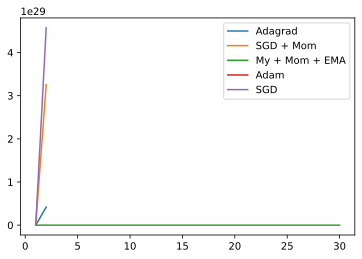

In [139]:
x = list(range(1, 31))
# plt.ylim(0.4, 1)
plt.plot(x, l1, label = "Adagrad")
plt.plot(x, l2, label = "SGD + Mom")
plt.plot(x, l3, label = "My + Mom + EMA")
plt.plot(x, l4, label = "Adam")
plt.plot(x, l5, label = "SGD")
plt.legend()
plt.show()

loss: 0.244, 0.054 sec/epoch


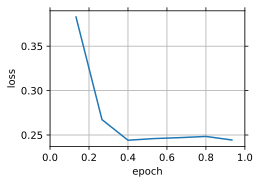

In [14]:
data_iter, _ = get_regression_data(batch_size = 10, normalized = True)
general_trainer(linear_regression, data_iter, tf.keras.losses.MeanSquaredError(), sgd, {'lr': 0.03}, 1)

loss: 0.442, 0.450 sec/epoch


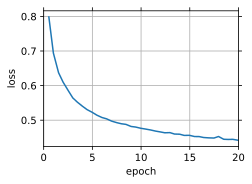

In [49]:
data_iter, test_iter = get_classification_data(batch_size=256, normalized = True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
general_trainer(fashion_mnist, data_iter, loss, sgd, {'lr': 0.05}, 20)

loss: 0.973, 0.499 sec/epoch


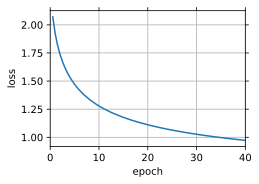

In [51]:
data_iter, test_iter = get_classification_data(batch_size=256, normalized = True)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
general_trainer(fashion_mnist, data_iter, loss, my_optimizer, {'power_factor': 2}, 40)

loss: 1.758, 0.506 sec/epoch


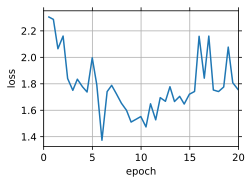

In [80]:
data_iter, test_iter = get_classification_data(batch_size=256, normalized = False)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
general_trainer(fashion_mnist_deep, data_iter, loss, sgd, {'lr': 0.08}, 20)

loss: 1.625, 0.621 sec/epoch


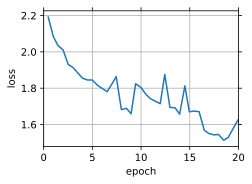

In [79]:
data_iter, test_iter = get_classification_data(batch_size=256, normalized = False)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
general_trainer(fashion_mnist_deep, data_iter, loss, my_optimizer, {'power_factor': 5}, 20)